In [1]:
# === Imports  ===

import os
import sys
import re
from pathlib import Path
import string

import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import jaccard_score
from scipy.spatial import cKDTree

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import trimesh
import networkx as nx


In [12]:
# === Project root and common paths ===
def find_project_root(start: Path = Path.cwd()):
    cur = start.resolve()
    for _ in range(5): 
        if (cur / "src").is_dir() and (cur / "data").is_dir():
            return cur
        cur = cur.parent
    raise RuntimeError("Cannot locate project root containing src/ and data/")

ROOT = find_project_root()
SRC  = ROOT / "src"
DATA = ROOT / "data"
FIGS = ROOT / "figures"
MODELS = ROOT / "models"

if str(SRC) not in sys.path:
    sys.path.append(str(SRC))


PTS_DIR   = DATA / "points"
GRAPH_DIR = DATA / "graphs"
ORC_DIR   = DATA / "orc"
ORCW_DIR  = DATA / "orc_weight"
FRC_DIR   = DATA / "frc"

FIGS.mkdir(parents=True, exist_ok=True)

print("ROOT =", ROOT)


ROOT = /Users/hazel/Desktop/ricci-benchmark


In [3]:
# === Data loaders ===
def load_points(tag: str):
    """tag 形如 'torus_n500_noise0.010_rep0'"""
    d = np.load(PTS_DIR / f"{tag}.npz")
    X = d["X"]
    R_true = d.get("R_true", None)
    return X, R_true

def load_graph(tag: str):
    d = np.load(GRAPH_DIR / f"{tag}.npz")
    D = sp.csr_matrix(d["D"])
    h = d.get("h", np.array([np.nan]))[0]
    r = d.get("r", None)
    return D, h, r

def load_orc(tag: str):
    d = np.load(ORC_DIR / f"{tag}_orc.npz")
    return d["ricci_node"], d["ricci_edge"], d["edge_u"], d["edge_v"]

def load_orc_weight(tag: str):
    d = np.load(ORCW_DIR / f"{tag}_orc.npz")
    return d["ricci_node"], d["ricci_edge"], d["edge_u"], d["edge_v"]

def load_frc(tag: str):
    d = np.load(FRC_DIR / f"{tag}_forman.npz")
    return d["forman_node"], d["forman_edge"], d["edge_u"], d["edge_v"]


In [4]:
# === Key metric summary table (varing ground truth) ===
pat = re.compile(r"^(?P<manifold>.+?)_n(?P<n>\d+)_noise(?P<noise>[0-9.]+)_rep(?P<rep>\d+)$")

def compute_sign_match_rate(proxy: np.ndarray, R_true: np.ndarray) -> float:
    mask = np.isfinite(proxy) & np.isfinite(R_true)
    return float(np.mean(np.sign(proxy[mask]) == np.sign(R_true[mask])))

def topk_mask(values: np.ndarray, k_ratio: float = 0.1) -> np.ndarray:
    mask = np.zeros_like(values, dtype=int)
    k = int(len(values) * k_ratio)
    if k == 0:
        return mask
    idx = np.argsort(values)[-k:]
    mask[idx] = 1
    return mask

def compute_jaccard_index(true: np.ndarray, proxy: np.ndarray, k_ratio: float = 0.1) -> float:
    mask = np.isfinite(true) & np.isfinite(proxy)
    if mask.sum() == 0:
        return np.nan
    gt_topk = topk_mask(true[mask], k_ratio)
    pr_topk = topk_mask(proxy[mask], k_ratio)
    return jaccard_score(gt_topk, pr_topk)

def compute_precision_at_k(true: np.ndarray, proxy: np.ndarray, k_ratio: float = 0.1) -> float:
    mask = np.isfinite(true) & np.isfinite(proxy)
    if mask.sum() == 0:
        return np.nan
    gt_topk = topk_mask(true[mask], k_ratio)
    pr_topk = topk_mask(proxy[mask], k_ratio)
    if pr_topk.sum() == 0:
        return np.nan
    return float(np.sum((gt_topk == 1) & (pr_topk == 1)) / pr_topk.sum())

rows = []
for orc_file in ORC_DIR.glob("*_orc.npz"):
    stem_core = orc_file.stem.replace("_orc", "")
    frc_file  = FRC_DIR / f"{stem_core}_forman.npz"
    pts_file  = PTS_DIR / f"{stem_core}.npz"

    if not frc_file.exists():
        print(f"[X] Missing FRC: {frc_file.name}")
    if not pts_file.exists():
        print(f"[X] Missing Points: {pts_file.name}")

    m = pat.match(stem_core)
    if not m:
        print(f"[X] Regex mismatch: {stem_core}")
        continue

    fields = m.groupdict()
    mf     = fields["manifold"]
    n      = int(fields["n"])
    noise  = float(fields["noise"])
    rep    = int(fields["rep"])

    R_true              = load_points(stem_core)[1]
    orc_node, _, _, _   = load_orc(stem_core)
    frc_node, _, _, _   = load_frc(stem_core)


    orc_s, orc_sp = spearmanr(R_true, orc_node)
    frc_s, frc_sp = spearmanr(R_true, -frc_node)

    orc_r, orc_rp = pearsonr(R_true, orc_node)
    frc_r, frc_rp = pearsonr(R_true, -frc_node)

    orc_match = compute_sign_match_rate(orc_node, R_true)
    frc_match = compute_sign_match_rate(-frc_node, R_true)

    jacc_orc = compute_jaccard_index(R_true, orc_node)
    jacc_frc = compute_jaccard_index(R_true, -frc_node)
    prec_orc = compute_precision_at_k(R_true, orc_node)
    prec_frc = compute_precision_at_k(R_true, -frc_node)

    rows.append(dict(
        manifold=mf, n=n, noise=noise, rep=rep,
        orc_s=orc_s,  orc_sp=orc_sp,
        frc_s=frc_s,  frc_sp=frc_sp,
        orc_r=orc_r,  orc_rp=orc_rp,
        frc_r=frc_r,  frc_rp=frc_rp,
        orc_match=orc_match,
        frc_match=frc_match,
        jacc_orc=jacc_orc,
        jacc_frc=jacc_frc,
        prec_orc=prec_orc,
        prec_frc=prec_frc
    ))

df = (pd.DataFrame(rows)
      .dropna(subset=["orc_s", "frc_s", "orc_r", "frc_r"])
      .sort_values(["manifold", "n", "noise", "rep"])
      .reset_index(drop=True))


/var/folders/r0/hbf53mk56p9911j200ygwy_c0000gn/T/ipykernel_30506/4150905207.py:62: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  orc_s, orc_sp = spearmanr(R_true, orc_node)
/var/folders/r0/hbf53mk56p9911j200ygwy_c0000gn/T/ipykernel_30506/4150905207.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  frc_s, frc_sp = spearmanr(R_true, -frc_node)
/var/folders/r0/hbf53mk56p9911j200ygwy_c0000gn/T/ipykernel_30506/4150905207.py:65: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  orc_r, orc_rp = pearsonr(R_true, orc_node)
/var/folders/r0/hbf53mk56p9911j200ygwy_c0000gn/T/ipykernel_30506/4150905207.py:66: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  frc_r, frc_rp = pearsonr(R_true, -frc_node)
/var/folders/r0/hbf53mk56p9911j200ygwy_c0000gn/T/ipykernel_30506/4150905207.py:62: ConstantInputWarning: An 

In [5]:
# === Key metric summary table (fixed ground truth) ===
pat = re.compile(r"(?P<manifold>\w+)_n(?P<n>\d+)_noise(?P<noise>[\d.]+)_rep(?P<rep>\d+)")
fixed_manifolds = {"sphere", "plane"}

rows = []
for orc_file in ORC_DIR.glob("*_orc.npz"):
    stem_core = orc_file.stem.replace("_orc", "")
    frc_file  = FRC_DIR / f"{stem_core}_forman.npz"
    pts_file  = PTS_DIR / f"{stem_core}.npz"

    m = pat.match(stem_core)
    if not m:
        continue
    mf, n, noise, rep = m.group("manifold"), int(m.group("n")), float(m.group("noise")), int(m.group("rep"))
    if mf not in fixed_manifolds:
        continue

    try:
        _, R_true           = load_points(stem_core)
        frc_node, _, _, _   = load_frc(stem_core)
        orc_node, _, _, _   = load_orc(stem_core)
    except Exception:
        continue

    if np.isnan(orc_node).any() or np.isnan(frc_node).any() or np.isnan(R_true).any():
        continue

    orc_mean = float(np.mean(orc_node))
    frc_mean = float(np.mean(frc_node))
    orc_sd   = float(np.std(orc_node))
    frc_sd   = float(np.std(frc_node))
    orc_cv   = orc_sd / abs(orc_mean) if orc_mean != 0 else np.nan
    frc_cv   = frc_sd / abs(frc_mean) if frc_mean != 0 else np.nan

    orc_med  = float(np.median(orc_node))
    frc_med  = float(np.median(frc_node))
    orc_mad  = float(np.median(np.abs(orc_node - orc_med)))
    frc_mad  = float(np.median(np.abs(frc_node - frc_med)))

    rows.append(dict(
        manifold=mf, n=n, noise=noise, rep=rep,
        orc_mean=orc_mean, orc_sd=orc_sd, orc_cv=orc_cv, orc_mad=orc_mad,
        frc_mean=frc_mean, frc_sd=frc_sd, frc_cv=frc_cv, frc_mad=frc_mad
    ))

fixed_df = (pd.DataFrame(rows)
            .sort_values(["manifold","n","noise","rep"])
            .reset_index(drop=True))


In [6]:
# === Enrichment Ratio (synthetic manifold) ===

from ricci_benchmark.utils_analysis import (
    select_topk_from_df,
    compute_er_pos_simple,
    run_manifold_for_proxy,
    show_er_table,
)

show_er_table(
    df, manifold="paraboloid", proxy="frc",
    k=10, reps=range(5), q_tail=10.0, alpha=0.30,
    load_points=load_points, load_orc=load_orc, load_frc=load_frc
)

show_er_table(
    df, manifold="torus", proxy="orc",
    k=10, reps=range(5), q_tail=10.0, alpha=0.30,
    load_points=load_points, load_orc=load_orc, load_frc=load_frc
)

show_er_table(
    df, manifold="saddle", proxy="orc",
    k=10, reps=range(5), q_tail=10.0, alpha=0.30,
    load_points=load_points, load_orc=load_orc, load_frc=load_frc
)

show_er_table(
    df, manifold="saddle", proxy="frc",
    k=10, reps=range(5), q_tail=10.0, alpha=0.30,
    load_points=load_points, load_orc=load_orc, load_frc=load_frc
)

=== Paraboloid — FRC (ER) ===
  manifold    n  noise proxy  ER_high_upper_mean  ER_low_lower_mean
paraboloid  500   0.01   frc            3.026667           1.200000
paraboloid  500   0.03   frc            2.653333           1.133333
paraboloid  500   0.05   frc            2.520000           1.240000
paraboloid  500   0.07   frc            2.266667           1.360000
paraboloid 1000   0.03   frc            2.500000           1.133333
paraboloid 1000   0.05   frc            2.386667           1.386667
paraboloid 1000   0.07   frc            1.846667           1.406667
paraboloid 2000   0.03   frc            2.263333           1.446667
paraboloid 2000   0.05   frc            1.886667           1.566667
paraboloid 3000   0.03   frc            2.135556           1.664444
=== Torus — ORC (ER) ===
manifold    n  noise proxy  ER_high_upper_mean  ER_low_lower_mean
   torus  500   0.01   orc            1.520000           1.746667
   torus  500   0.03   orc            1.613333           1.560000

In [7]:
# === Outlier hit plot (complex model) ===
from ricci_benchmark.utils_analysis import (
    compute_outlier_consensus_core, build_hits_figure
)

def run_and_plot_hits_all_warm_side_by_side(
    manifold, mesh_path, n, noise, reps=range(5),
    *, tail="upper", q=5.0, scene_eye=None, scene2_eye=None,
    pad=0.03, marker_size=3.0, save_path=None
):
    V_orc, F_orc, pr_orc = compute_outlier_consensus_core(
        manifold, n, noise, reps, mesh_path,
        proxy="orc", tail=tail, q=q,
        load_points=load_points, load_orc=load_orc, load_frc=load_frc
    )
    V_frc, F_frc, pr_frc = compute_outlier_consensus_core(
        manifold, n, noise, reps, mesh_path,
        proxy="frc", tail=tail, q=q,
        load_points=load_points, load_orc=load_orc, load_frc=load_frc
    )

    title_left  = f"{manifold} · ORC · {tail} {q:.0f}%"
    title_right = f"{manifold} · FRC · {tail} {q:.0f}%"
    fig = build_hits_figure(
        V_orc, F_orc, pr_orc, V_frc, F_frc, pr_frc,
        title_left=title_left, title_right=title_right,
        marker_size=marker_size, pad=pad, scene_eye=scene_eye, scene2_eye=scene2_eye
    )
    if save_path:
        fig.write_image(save_path) 
    return fig


In [13]:
eye1 = dict(x=0, y=-0.35, z=2.13)
eye2 = dict(x=0, y=-0.35, z=2.13)

# Bunny Outlier hit
run_and_plot_hits_all_warm_side_by_side(
    manifold="bunny", mesh_path= MODELS / "bunny.obj",
    n=1000, noise=0.010, reps=range(5), tail="upper", q=5.0,
    scene_eye=eye1, scene2_eye=eye2,
    save_path= FIGS/"bunny_hits.pdf"
)



In [ ]:
eye1 = dict(x=0, y=-0.35, z=2.13)
eye2 = dict(x=0, y=-0.35, z=2.13)

# Teapot Outlier hit
run_and_plot_hits_all_warm_side_by_side(
    manifold="teapot", mesh_path= MODELS /"teapot.obj",
    n=1000, noise=0.010, reps=range(5), tail="upper", q=5.0,
    scene_eye=eye1, scene2_eye=eye2,
    save_path= FIGS/"teapot_hits.pdf"
)

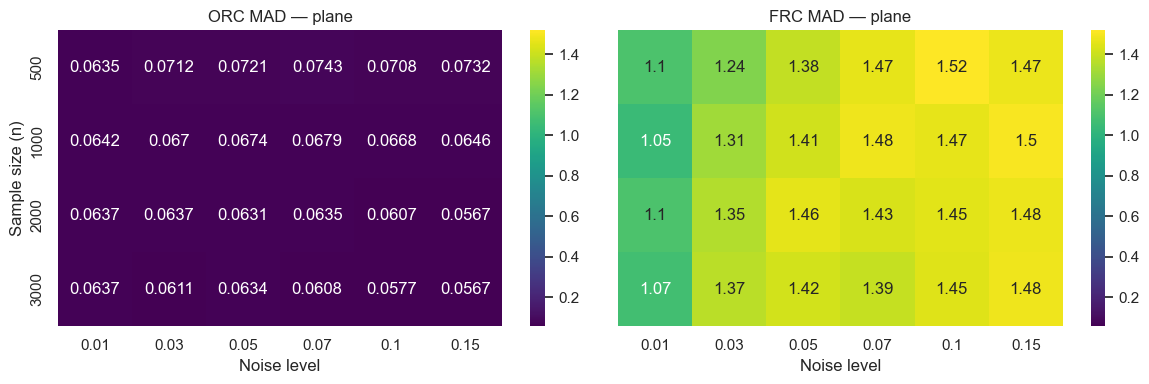

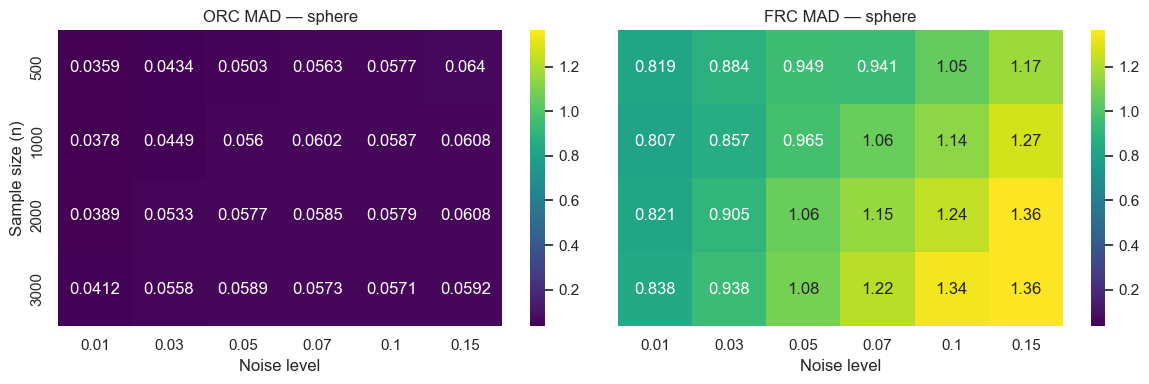

In [ ]:
# === Heatmap of MAD (Median Absolute Deviation) ===
sns.set(style="whitegrid")

agg = (fixed_df.groupby(["manifold","n","noise"], as_index=False)
       .agg(orc_mad=("orc_mad","mean"),
            frc_mad=("frc_mad","mean")))

agg["ratio_frc_over_orc"] = agg["frc_mad"] / np.maximum(agg["orc_mad"], 1e-12)

for mf in agg["manifold"].unique():
    sub = agg[agg["manifold"] == mf].copy()
    sub["noise"] = sub["noise"].astype(float)
    sub["n"] = sub["n"].astype(int)

    orc_p = (sub.pivot(index="n", columns="noise", values="orc_mad")
                 .sort_index(axis=0)
                 .sort_index(axis=1))
    frc_p = (sub.pivot(index="n", columns="noise", values="frc_mad")
                 .sort_index(axis=0)
                 .sort_index(axis=1))

    vmin = min(orc_p.min().min(), frc_p.min().min())
    vmax = max(orc_p.max().max(), frc_p.max().max())

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    sns.heatmap(orc_p, ax=axes[0], cmap="viridis",
                vmin=vmin, vmax=vmax, annot=True, fmt=".3g", cbar=True)
    axes[0].set_title(f"ORC MAD — {mf}")
    axes[0].set_ylabel("Sample size (n)")
    axes[0].set_xlabel("Noise level")

    sns.heatmap(frc_p, ax=axes[1], cmap="viridis",
                vmin=vmin, vmax=vmax, annot=True, fmt=".3g", cbar=True)
    axes[1].set_title(f"FRC MAD — {mf}")
    axes[1].set_ylabel("")
    axes[1].set_xlabel("Noise level")

    plt.tight_layout()
    save_path = FIGS / f"mad_heatmap_{mf.lower()}.pdf"
    plt.savefig(save_path, format="pdf", bbox_inches="tight")



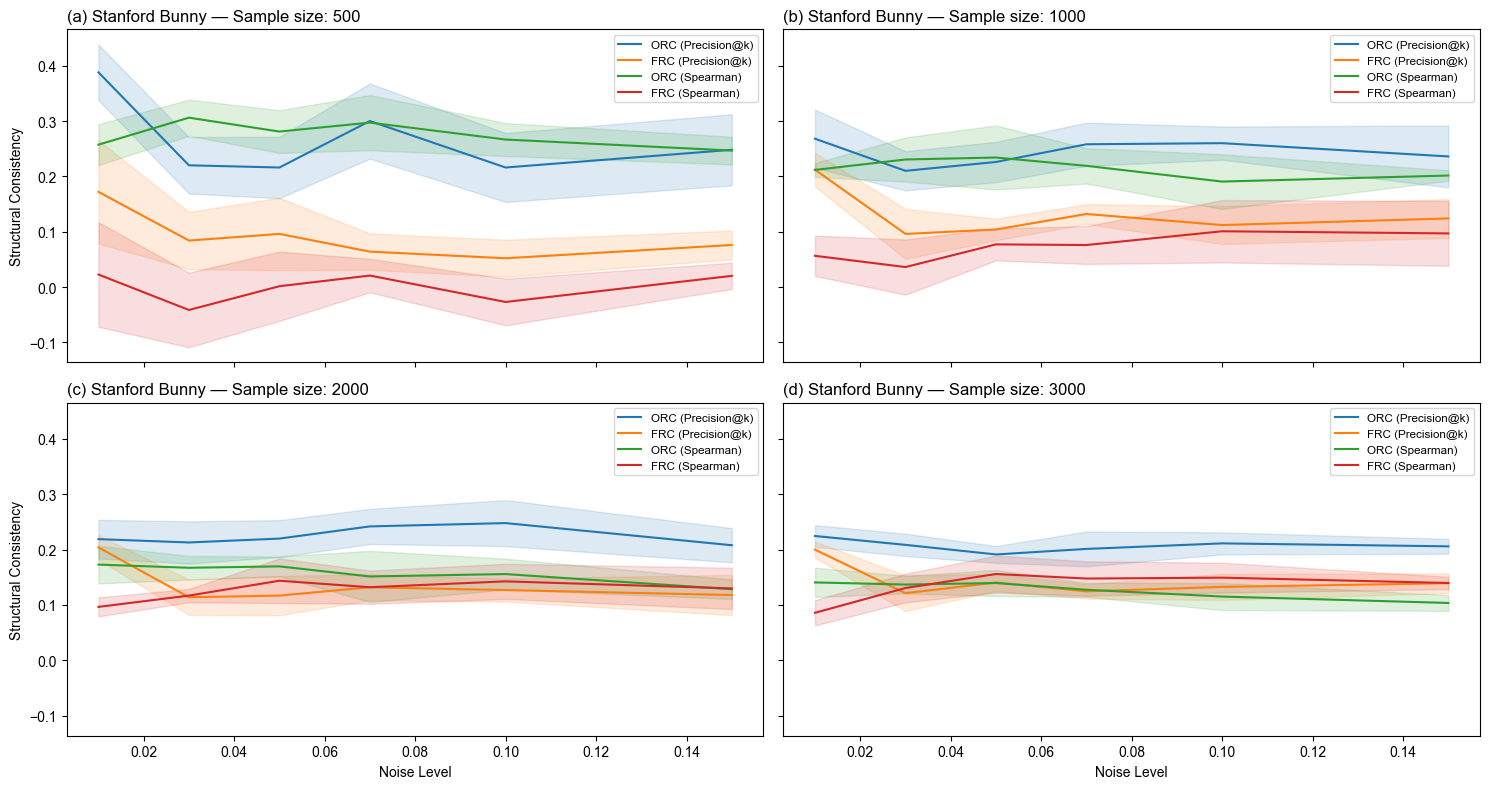

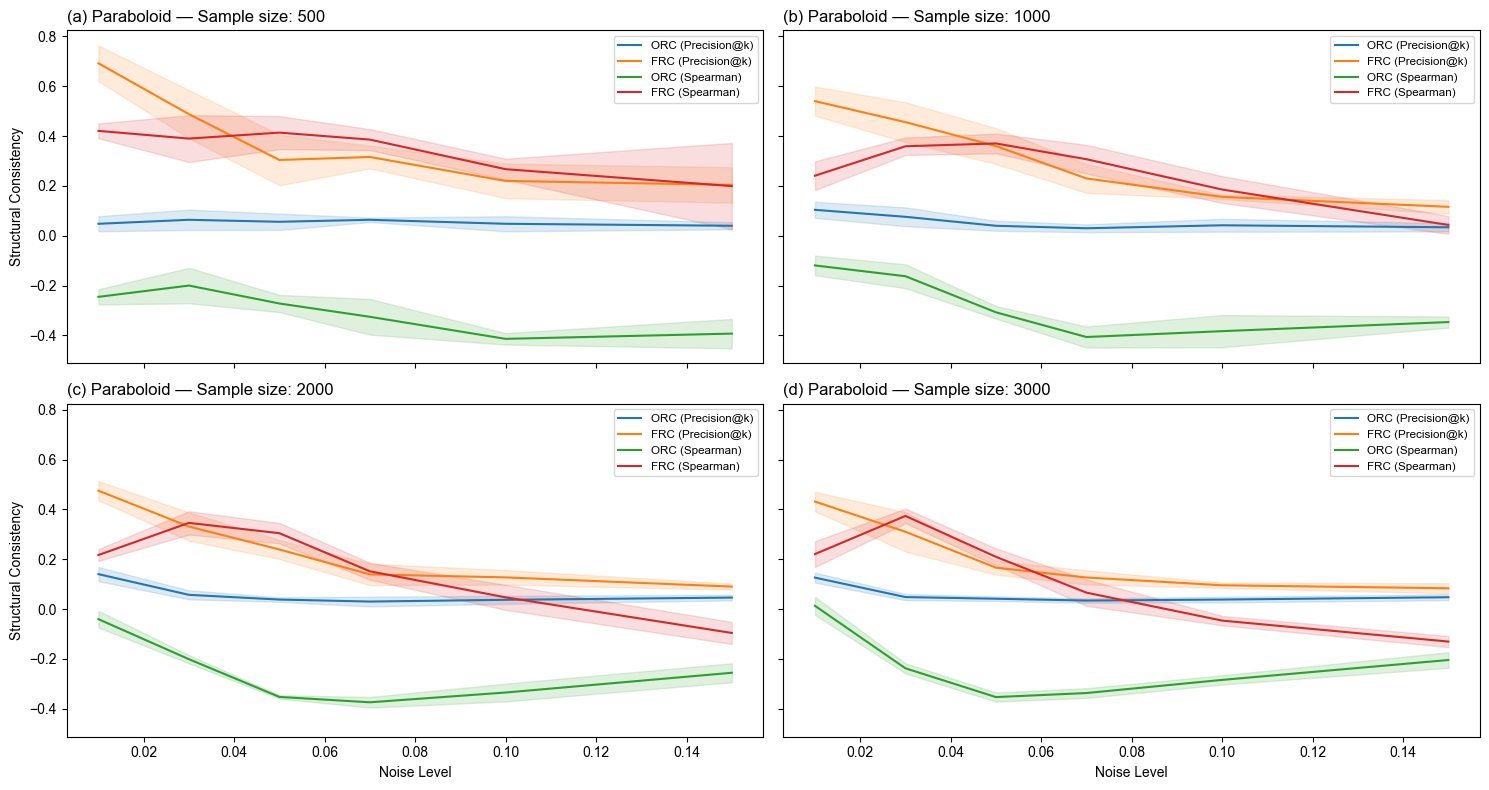

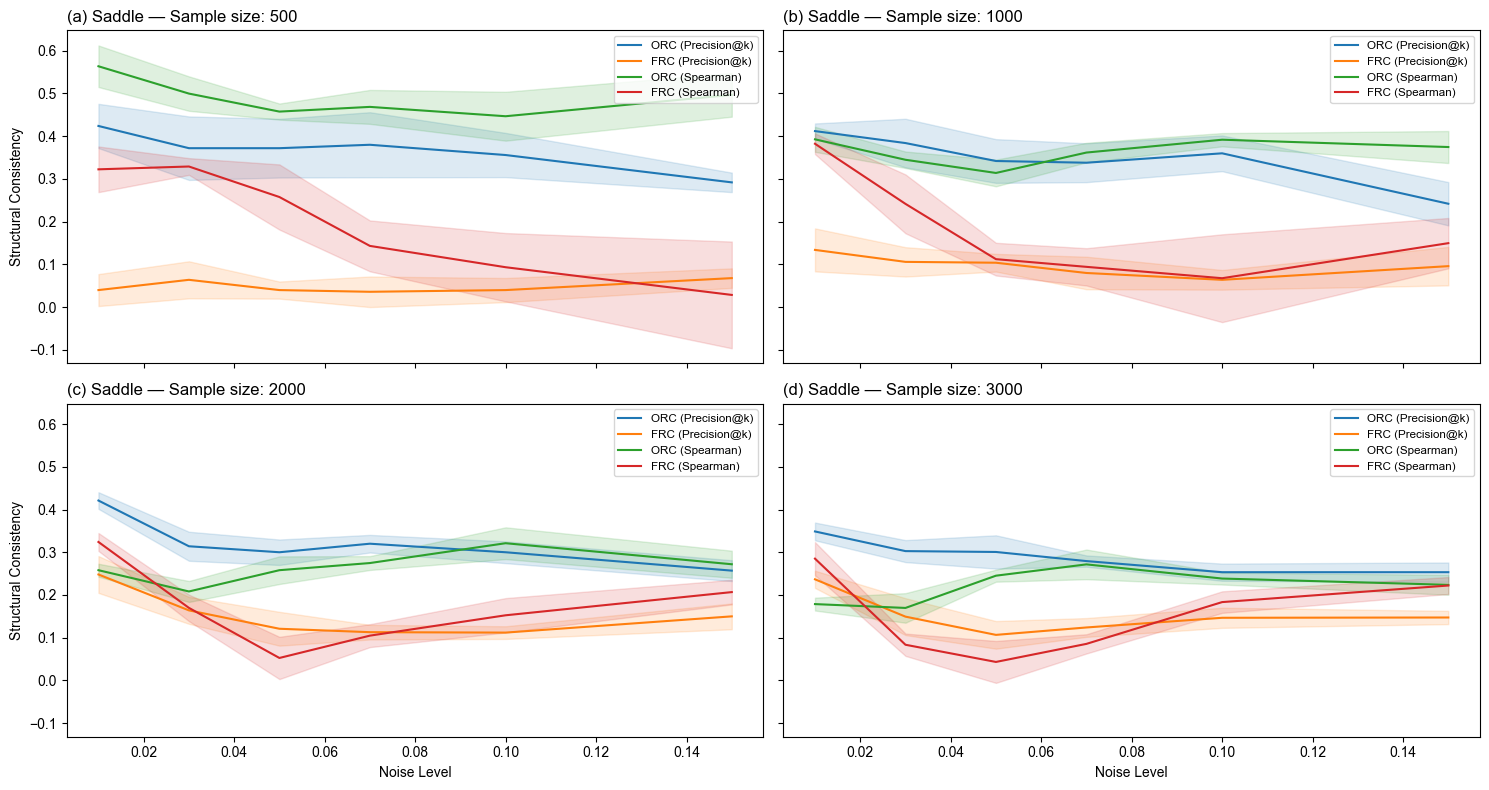

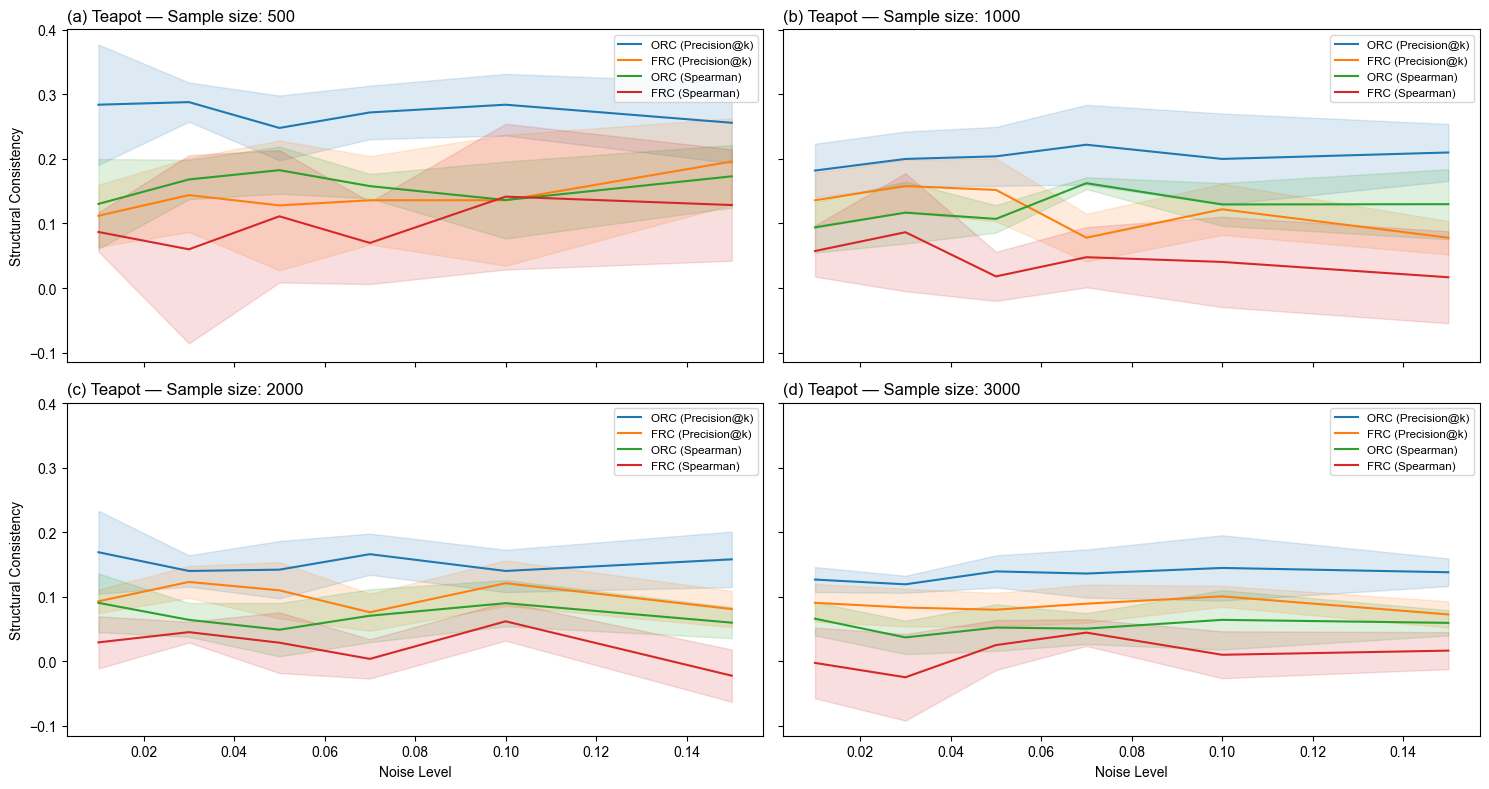

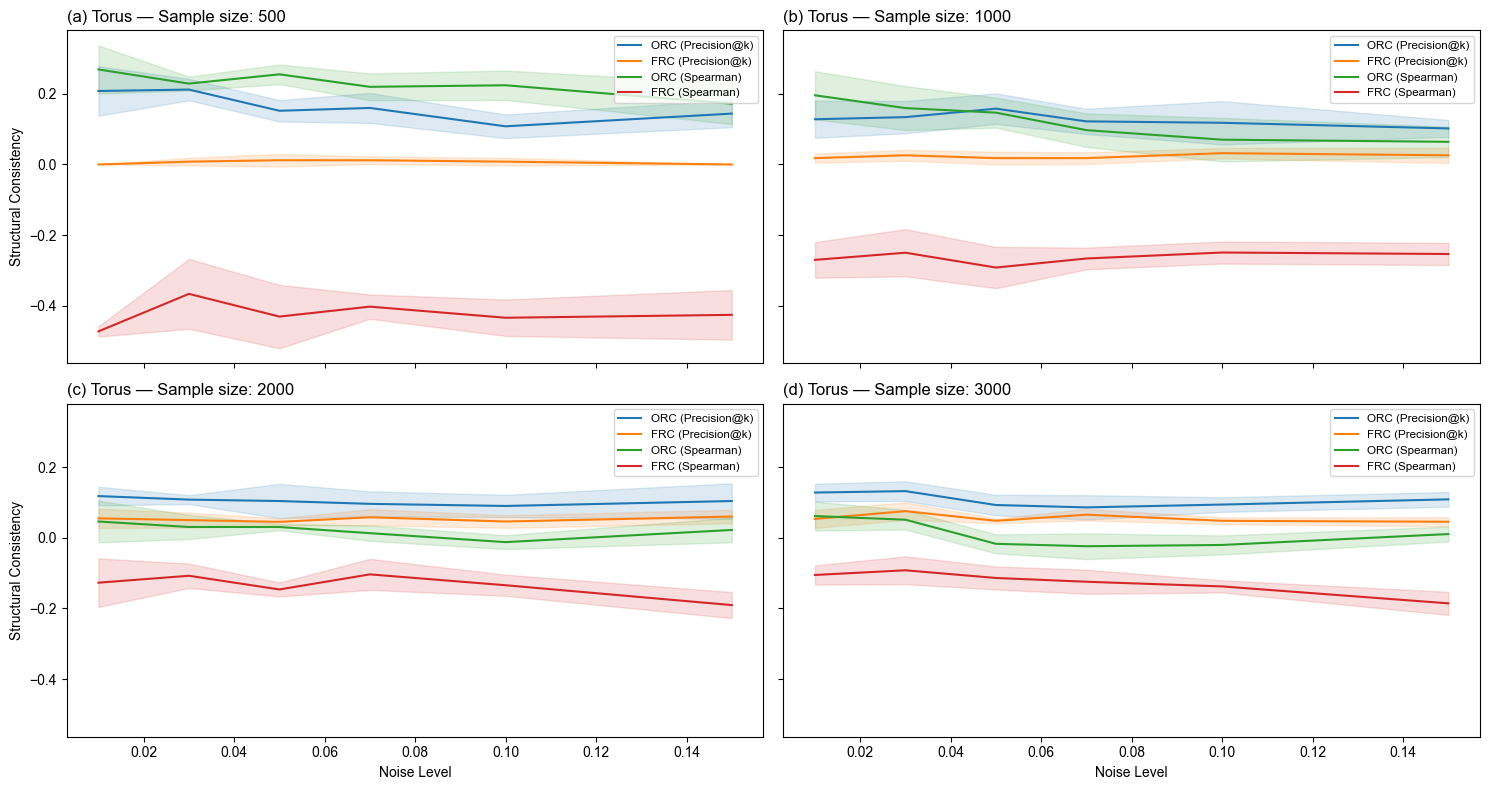

In [14]:
# === Linechart of key metrics across different noise level under fixed sample size  ===
plt.rcParams["font.family"] = "Arial"

for mf in df.manifold.unique():
    sub_mf = df[df.manifold == mf]
    sample_sizes = sorted(sub_mf.n.unique())
    n_plots = len(sample_sizes)

    n_cols = 2
    n_rows = (n_plots + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows), sharex=True, sharey=True)
    axes = axes.flatten()

    for idx, (n_val, ax) in enumerate(zip(sample_sizes, axes)):
        sub = sub_mf[sub_mf.n == n_val]

        sns.lineplot(data=sub, x="noise", y="prec_orc", label="ORC (Precision@k)", ax=ax,
                     errorbar="sd", err_kws={'alpha': 0.15})
        sns.lineplot(data=sub, x="noise", y="prec_frc", label="FRC (Precision@k)", ax=ax,
                     errorbar="sd", err_kws={'alpha': 0.15})

        sns.lineplot(data=sub, x="noise", y="orc_s", label="ORC (Spearman)", ax=ax,
                     errorbar="sd", err_kws={'alpha': 0.15})
        sns.lineplot(data=sub, x="noise", y="frc_s", label="FRC (Spearman)", ax=ax,
                     errorbar="sd", err_kws={'alpha': 0.15})

        letter = string.ascii_lowercase[idx]
        pretty = {
            "bunny": "Stanford Bunny",
            "teapot": "Teapot",
            "paraboloid": "Paraboloid",
            "saddle": "Saddle",
            "torus": "Torus",
        }.get(str(mf).lower(), str(mf).title())
        ax.set_title(f"({letter}) {pretty} — Sample size: {n_val}", loc="left")

        ax.set_xlabel("Noise Level")
        ax.set_ylabel("Structural Consistency")
        ax.legend(loc="upper right", fontsize="small", frameon=True)

    for j in range(len(sample_sizes), len(axes)):
        axes[j].axis("off")

    fig.tight_layout()
    save_path = FIGS / f"precision_spearman_noiseline_{mf.lower()}.pdf"
    plt.savefig(save_path, format="pdf", bbox_inches="tight")



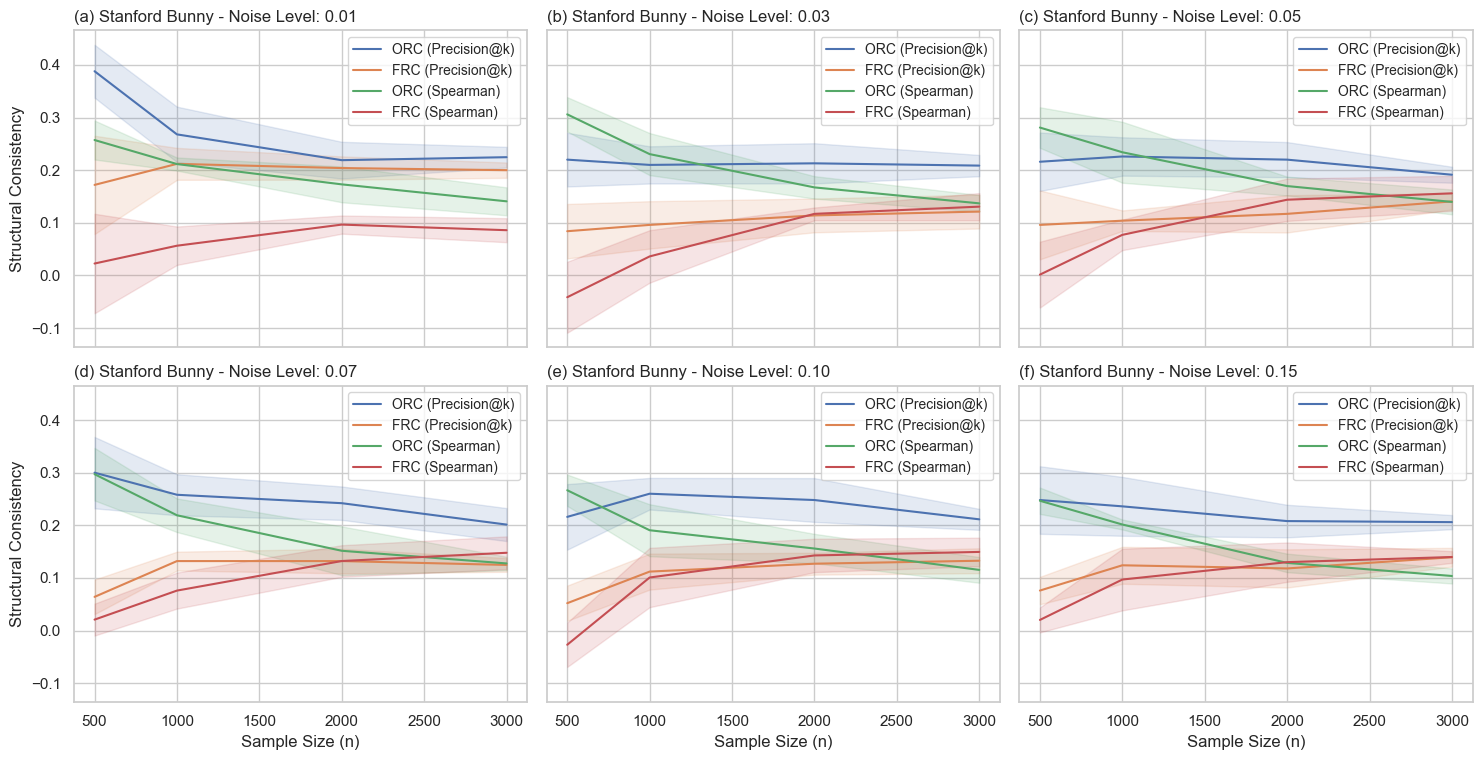

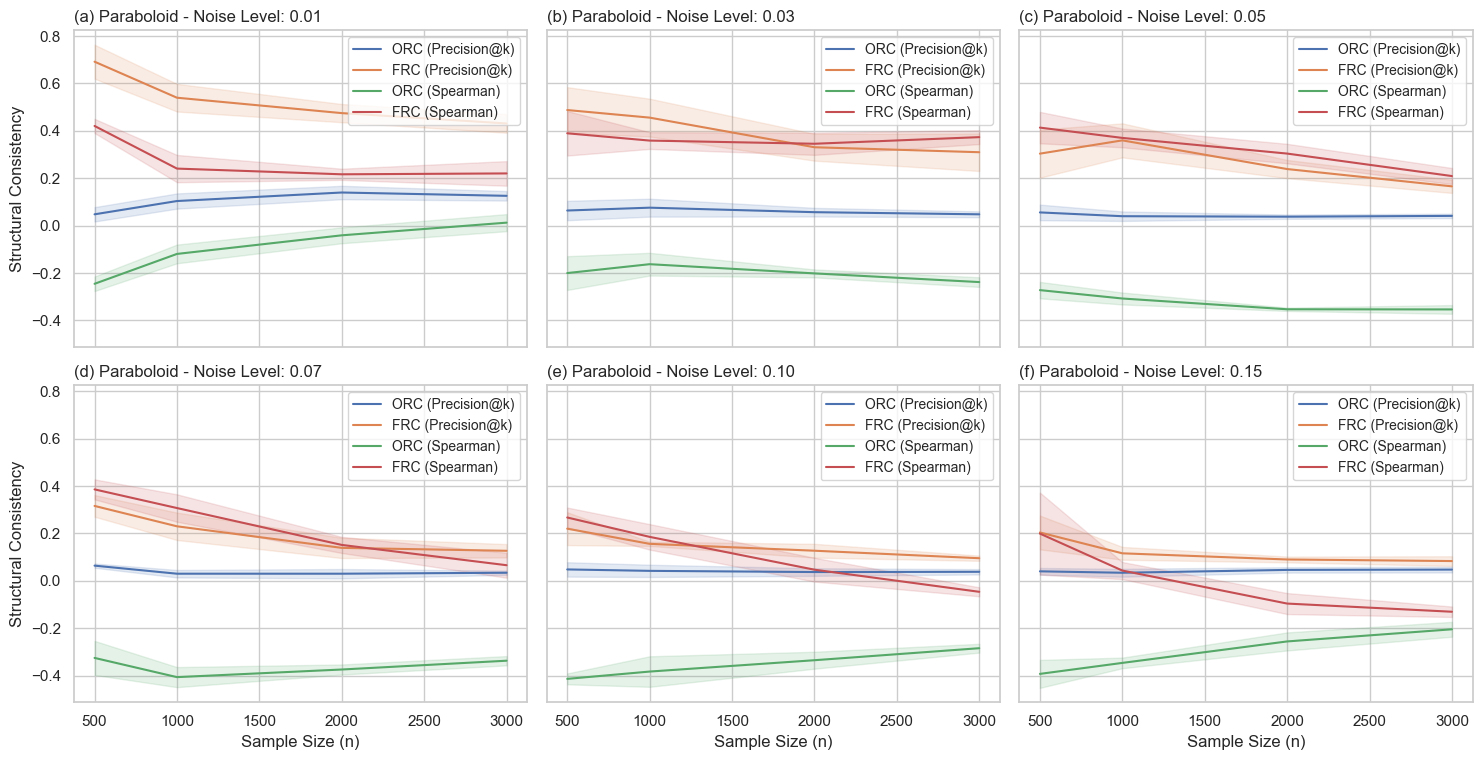

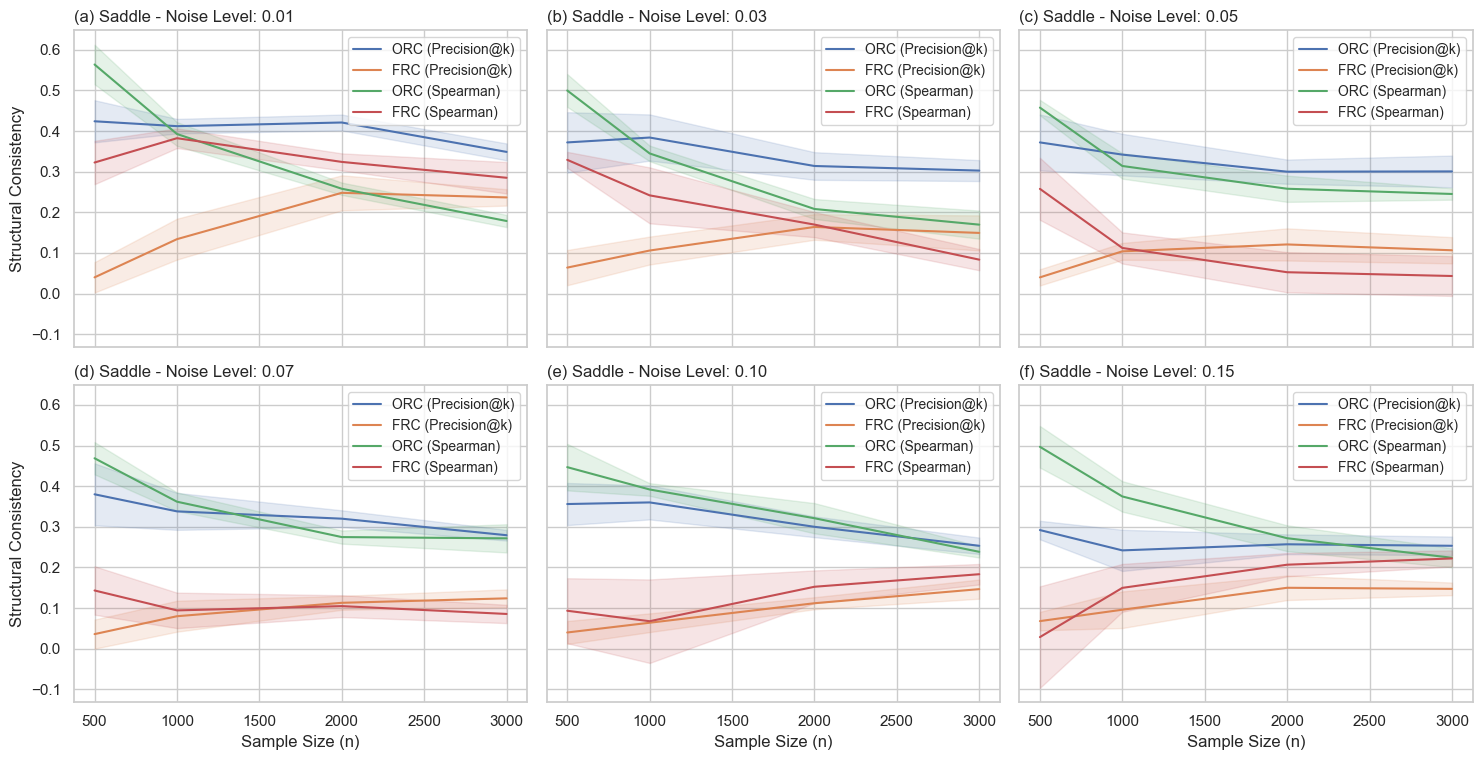

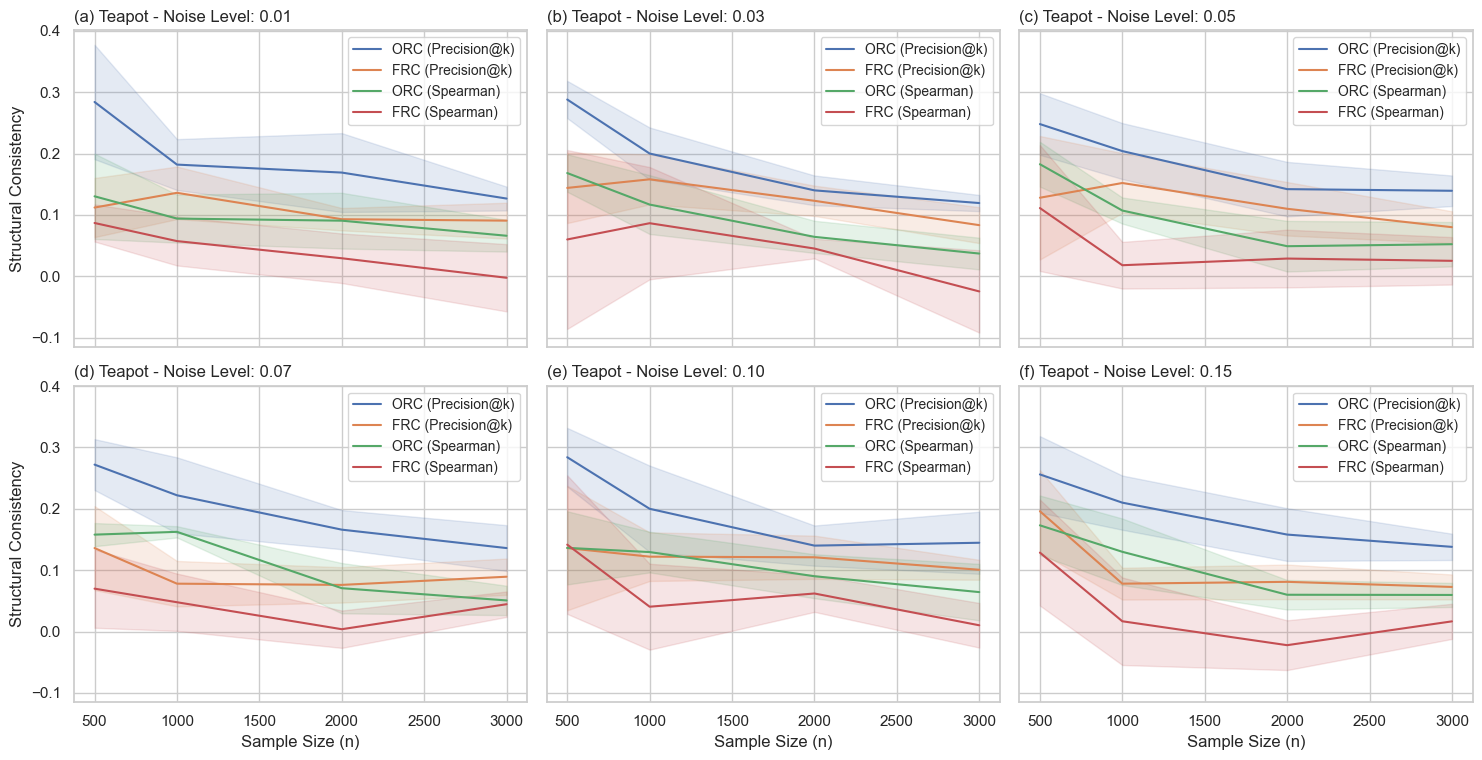

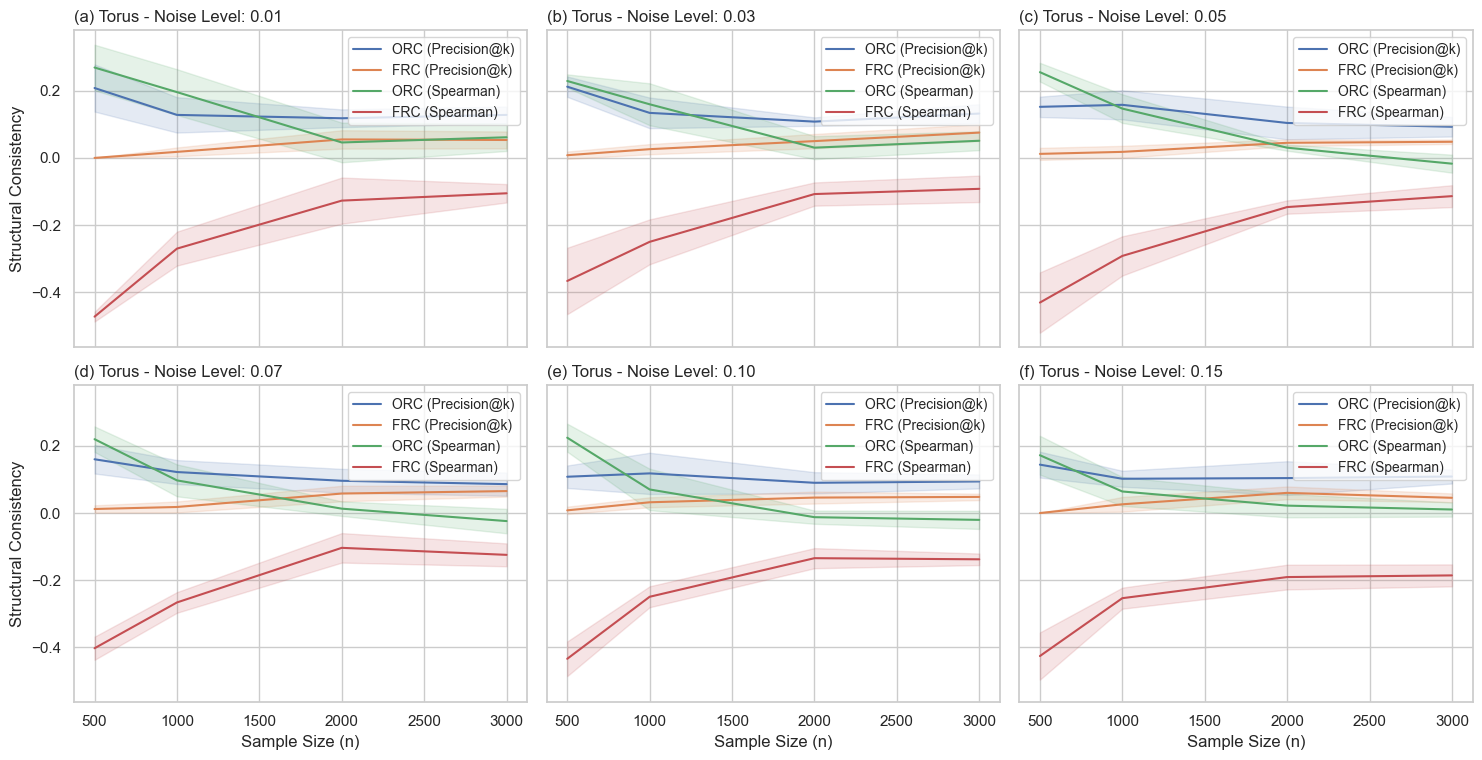

In [ ]:
# === Linechart of key metrics across different sample size under fixed noise level  ===
plt.rcParams["font.family"] = "Arial"

for mf in df.manifold.unique():
    sub_mf = df[df.manifold == mf]
    noise_levels = sorted(sub_mf.noise.unique())
    n_plots = len(noise_levels)

    n_cols = 3
    n_rows = (n_plots + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows), sharex=True, sharey=True)
    axes = axes.flatten()

    for idx, (noise, ax) in enumerate(zip(noise_levels, axes)):
        sub = sub_mf[sub_mf.noise == noise]

        sns.lineplot(data=sub, x="n", y="prec_orc", label="ORC (Precision@k)", ax=ax,
                     errorbar="sd", err_kws={'alpha': 0.15})
        sns.lineplot(data=sub, x="n", y="prec_frc", label="FRC (Precision@k)", ax=ax,
                     errorbar="sd", err_kws={'alpha': 0.15})
        sns.lineplot(data=sub, x="n", y="orc_s", label="ORC (Spearman)", ax=ax,
                     errorbar="sd", err_kws={'alpha': 0.15})
        sns.lineplot(data=sub, x="n", y="frc_s", label="FRC (Spearman)", ax=ax,
                     errorbar="sd", err_kws={'alpha': 0.15})

        letter = string.ascii_lowercase[idx]
        pretty = {
            "bunny": "Stanford Bunny",
            "teapot": "Teapot",
            "paraboloid": "Paraboloid",
            "saddle": "Saddle",
            "torus": "Torus",
        }.get(str(mf).lower(), str(mf).title())
        ax.set_title(f"({letter}) {pretty} - Noise Level: {noise:.2f}", loc="left")

        ax.set_xlabel("Sample Size (n)")
        ax.set_ylabel("Structural Consistency")
        ax.legend(loc="upper right", fontsize="small", frameon=True)

    for j in range(len(noise_levels), len(axes)):
        axes[j].axis("off")

    fig.tight_layout(rect=[0, 0, 1, 0.97])
    save_path = FIGS / f"precision_spearman_sizeline_{mf.lower()}.pdf"
    fig.savefig(save_path, format="pdf", bbox_inches="tight")


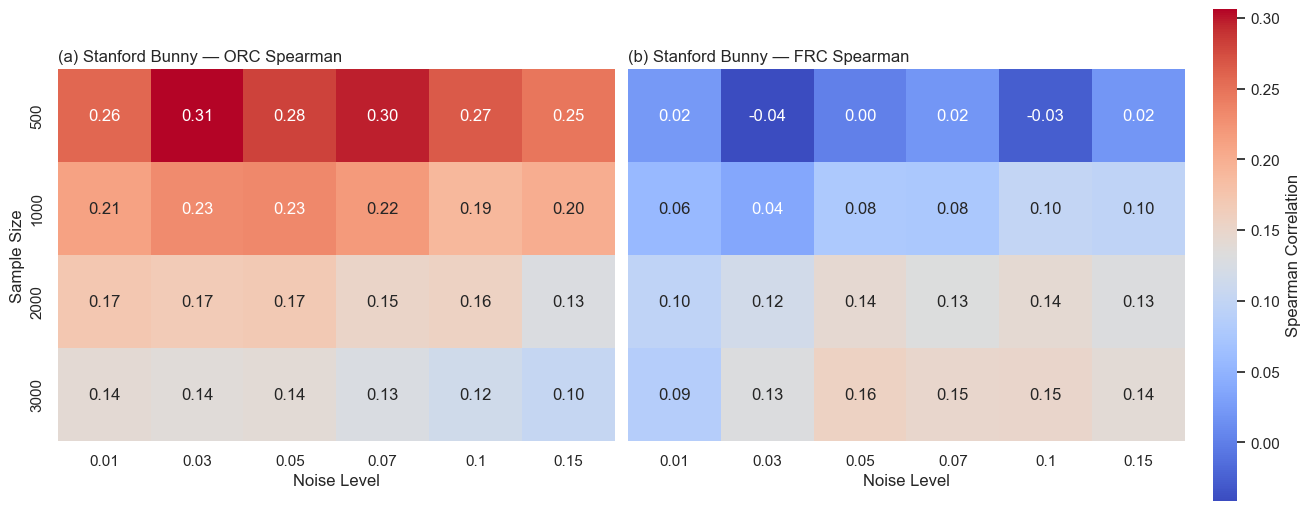

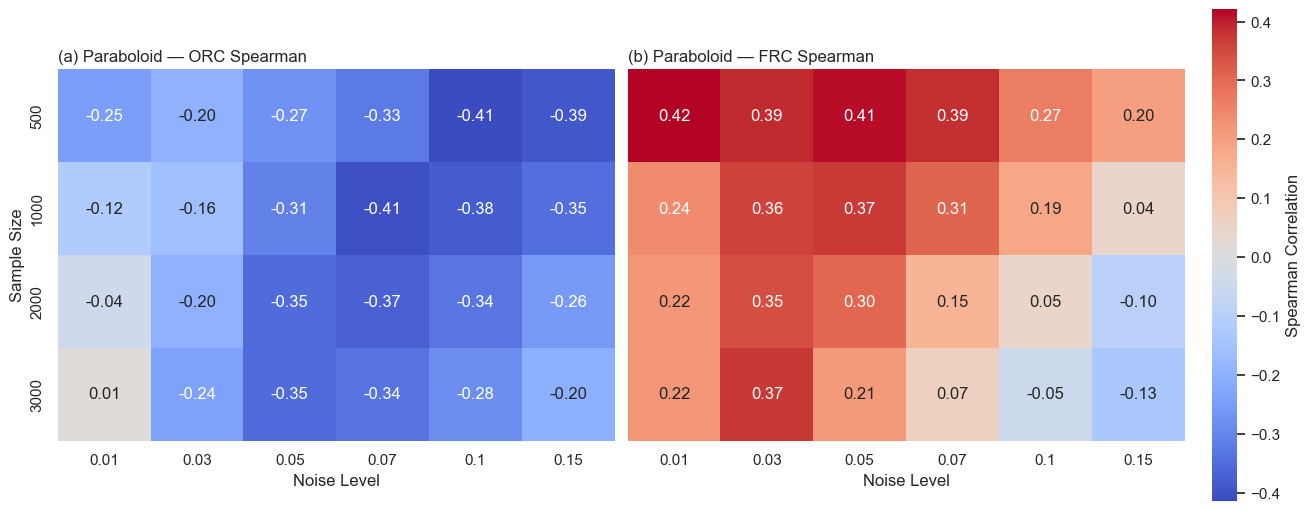

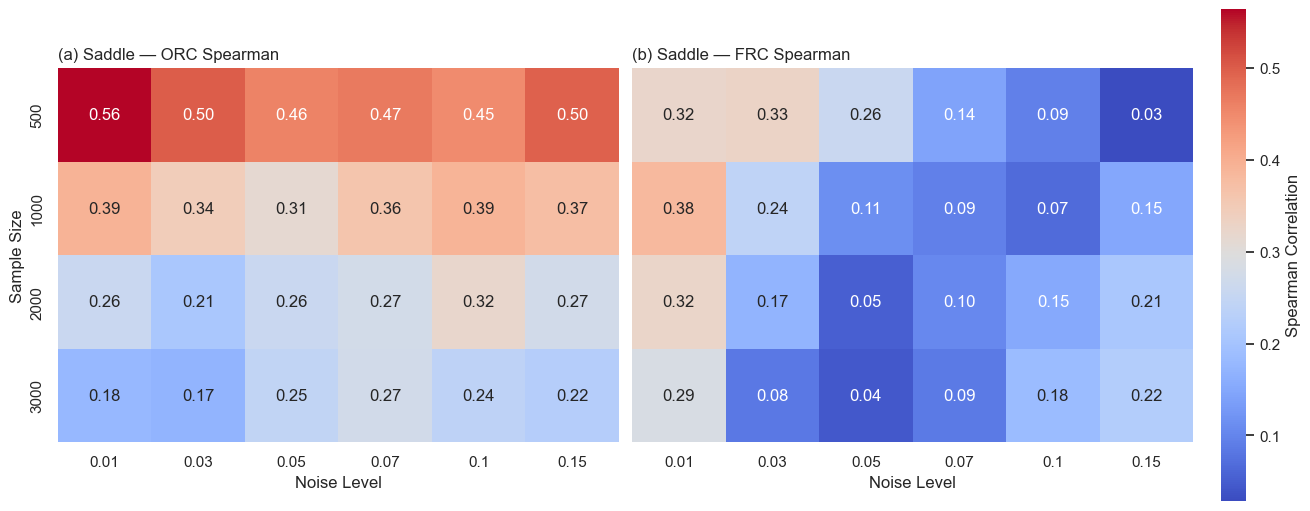

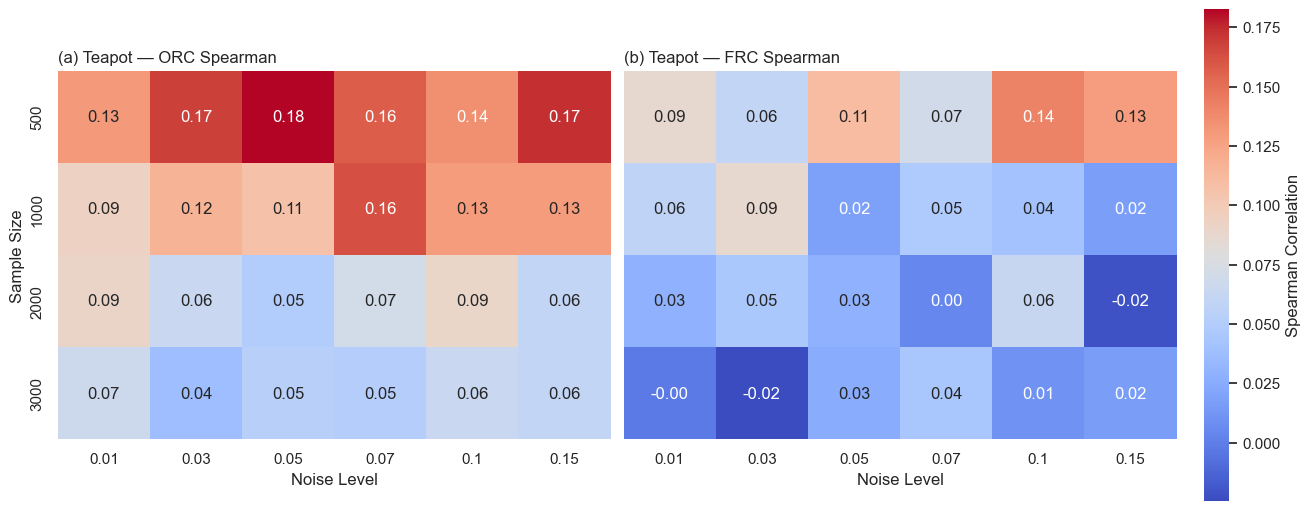

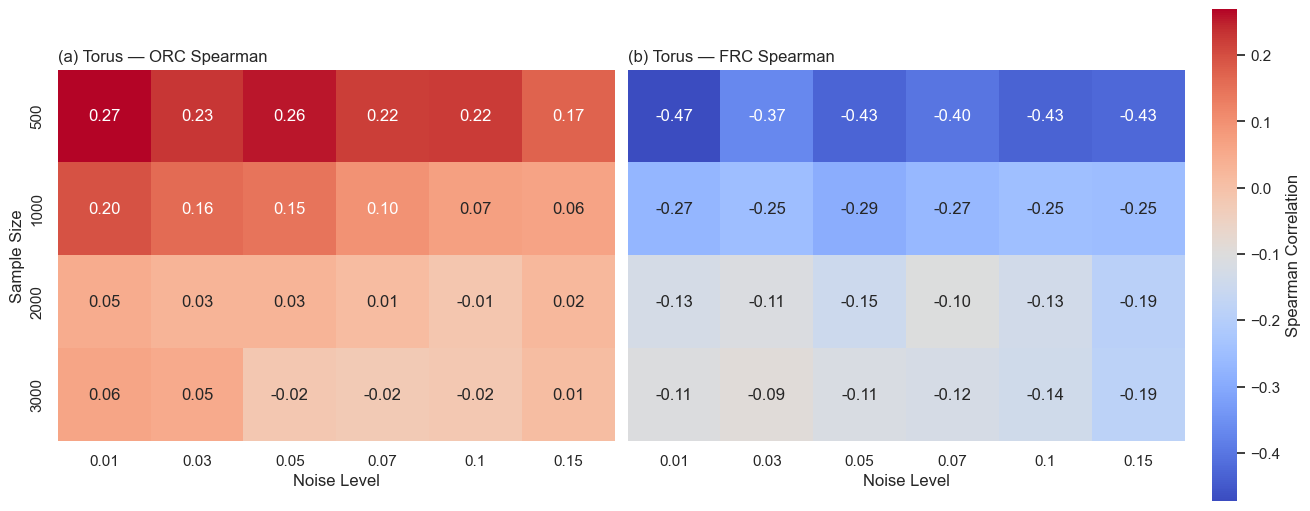

In [ ]:
# === Heatmap of Spreaman ===
agg_tbl = df.groupby(["manifold", "noise", "n"]).agg(
    orc_s_mean=("orc_s", "mean"),
    frc_s_mean=("frc_s", "mean")
).reset_index()

manifolds = df["manifold"].unique()

for mf in manifolds:
    sub_tbl = agg_tbl[agg_tbl.manifold == mf]

    orc_tbl = sub_tbl.pivot(index="n", columns="noise", values="orc_s_mean")
    frc_tbl = sub_tbl.pivot(index="n", columns="noise", values="frc_s_mean")
    combined = pd.concat([orc_tbl, frc_tbl])
    vmin, vmax = combined.min().min(), combined.max().max()

    fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharey=True, constrained_layout=True)

    # ORC
    sns.heatmap(orc_tbl, annot=True, cmap="coolwarm", fmt=".2f",
                vmin=vmin, vmax=vmax, cbar=False, ax=axes[0], square=True)
    pretty = {
        "bunny": "Stanford Bunny",
        "teapot": "Teapot",
        "paraboloid": "Paraboloid",
        "saddle": "Saddle",
        "torus": "Torus",
    }.get(str(mf).lower(), str(mf).title())
    axes[0].set_title(f"(a) {pretty} — ORC Spearman", loc="left")
    axes[0].set_xlabel("Noise Level")
    axes[0].set_ylabel("Sample Size")

    # FRC
    sns.heatmap(frc_tbl, annot=True, cmap="coolwarm", fmt=".2f",
                vmin=vmin, vmax=vmax, cbar=True, ax=axes[1], square=True,
                cbar_kws={"label": "Spearman Correlation"})
    axes[1].set_title(f"(b) {pretty} — FRC Spearman", loc="left")
    axes[1].set_xlabel("Noise Level")
    axes[1].set_ylabel("")

    save_path = FIGS / f"spearman_heatmap_{mf.lower()}.pdf"
    plt.savefig(save_path, format="pdf", bbox_inches="tight")



/var/folders/r0/hbf53mk56p9911j200ygwy_c0000gn/T/ipykernel_20823/791271612.py:34: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/var/folders/r0/hbf53mk56p9911j200ygwy_c0000gn/T/ipykernel_20823/791271612.py:35: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



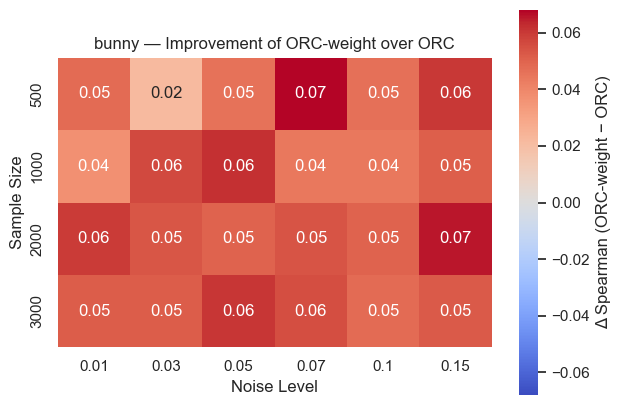

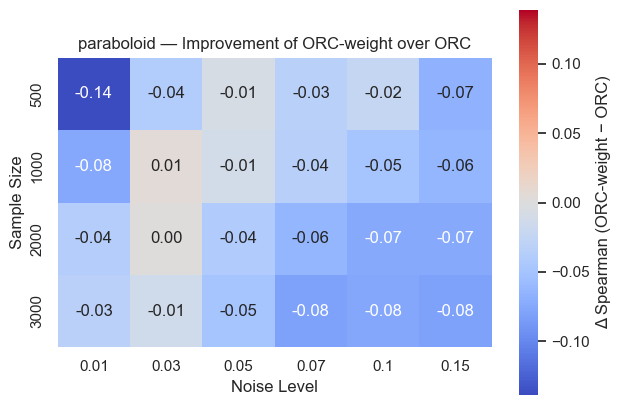

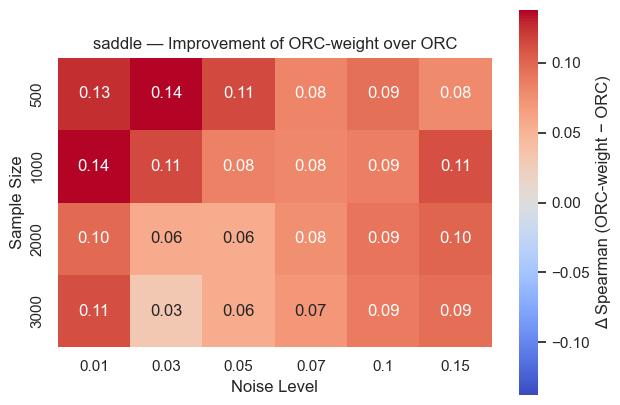

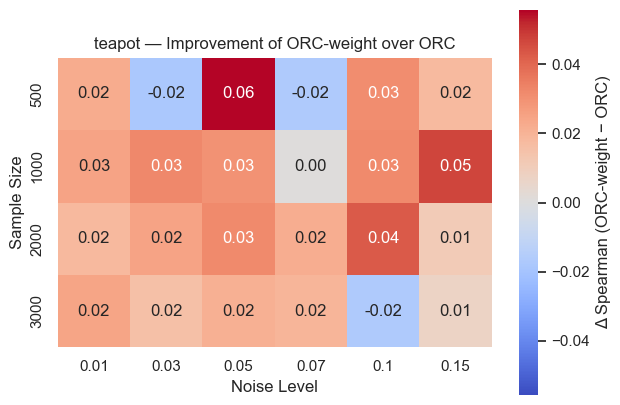

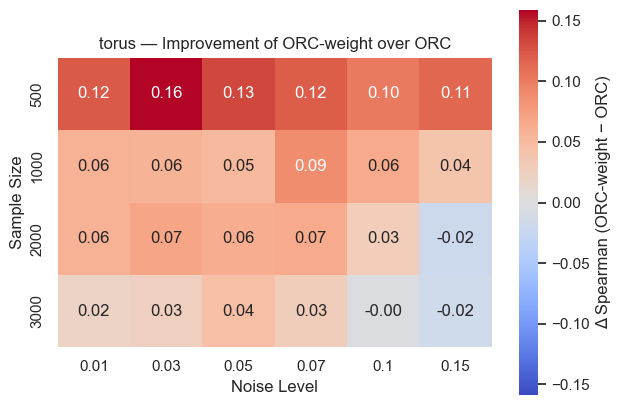

In [ ]:
# === Heatmap of improvement between ORC and ORC weight ===
# ORC is the proxy aggregate by 1/d.    
# ORC weight is the  proxy aggregate by d
pat = re.compile(r"^(?P<manifold>.+?)_n(?P<n>\d+)_noise(?P<noise>[0-9.]+)_rep(?P<rep>\d+)$")

rows = []
for orc_file in ORC_DIR.glob("*_orc.npz"):
    tag = orc_file.stem.replace("_orc", "")   

    m = pat.match(tag)
    if not m:
        print(f"[skip] regex mismatch: {tag}")
        continue

    mf    = m.group("manifold")
    n     = int(m.group("n"))
    noise = float(m.group("noise"))
    rep   = int(m.group("rep"))

    try:
        _, R_true = load_points(tag)
        orc_node, _, _, _  = load_orc(tag)
        orcw_node, _, _, _ = load_orc_weight(tag)
    except Exception as e:
        print(f"[X] Failed loading {tag}: {e}")
        continue

    if len(R_true) != len(orc_node) or len(R_true) != len(orcw_node):
        print(f"[!] Length mismatch: {tag}")
        continue

    orc_s,  _ = spearmanr(R_true, orc_node)
    orcw_s, _ = spearmanr(R_true, orcw_node)

    rows.append(dict(
        manifold=mf, n=n, noise=noise, rep=rep,
        delta=orcw_s - orc_s
    ))

df_delta = pd.DataFrame(rows)

if df_delta.empty:
    print("[!] No valid delta entries, skipping aggregation and plotting.")
else:
    df_delta = (df_delta
                .dropna(subset=["delta"])
                .sort_values(["manifold", "n", "noise", "rep"])
                .reset_index(drop=True))

    agg_delta = (df_delta
                 .groupby(["manifold", "noise", "n"], as_index=False)
                 .agg(delta_mean=("delta","mean")))

    for mf in agg_delta["manifold"].unique():
        sub = agg_delta[agg_delta.manifold == mf].copy()
        delta_tbl = sub.pivot(index="n", columns="noise", values="delta_mean")

        vmin = -max(abs(delta_tbl.min().min()), abs(delta_tbl.max().max()))
        vmax =  max(abs(delta_tbl.min().min()), abs(delta_tbl.max().max()))

        plt.figure(figsize=(7,5))
        sns.heatmap(delta_tbl, annot=True, cmap="coolwarm", fmt=".2f",
                    vmin=vmin, vmax=vmax, square=True,
                    cbar_kws={"label": "Δ Spearman (ORC-weight − ORC)"})
        plt.title(f"{mf} — Improvement of ORC-weight over ORC")
        plt.xlabel("Noise Level")
        plt.ylabel("Sample Size")

        out_pdf = FIGS / f"heatmap_delta_orcweight_{mf}.pdf"
        plt.savefig(out_pdf, format="pdf", bbox_inches="tight")



In [ ]:
# === stable ranges table ===
def summarize_stable_ranges_topk(agg_tbl, min_corr, min_cells, top_k):
    """
    Summarize stable (n, noise) ranges for ORC/FRC.
    Rules:
      1) Keep only grid points with Spearman >= min_corr
      2) If fewer than min_cells -> return 'None'
      3) Otherwise, take Top-K grid points by Spearman and report min–max ranges
    """
    records = []
    proxies = {"ORC": "orc_s_mean", "FRC": "frc_s_mean"}

    agg_tbl = agg_tbl.copy()
    agg_tbl["n"] = agg_tbl["n"].astype(int)
    agg_tbl["noise"] = agg_tbl["noise"].astype(float)

    for mf, sub_mf in agg_tbl.groupby("manifold"):
        for proxy, col in proxies.items():
            sub = sub_mf[["n", "noise", col]].dropna().rename(columns={col: "spearman"})
            # keep only Spearman >= threshold
            good = sub[sub["spearman"] >= min_corr].sort_values("spearman", ascending=False)

            if len(good) < min_cells:
                n_range = "None"
                noise_range = "None"
            else:
                top = good.head(top_k)
                n_min, n_max = int(top["n"].min()), int(top["n"].max())
                noise_min, noise_max = float(top["noise"].min()), float(top["noise"].max())
                n_range = f"{n_min}–{n_max}" if n_min != n_max else f"{n_min}"
                noise_range = (f"{noise_min:.3g}–{noise_max:.3g}"
                               if noise_min != noise_max else f"{noise_min:.3g}")

            records.append({"manifold": mf, "proxy": proxy,
                            "n_range": n_range, "noise_range": noise_range})

    summary = pd.DataFrame(records)
    # reshape to wide format (ORC/FRC in same row)
    summary_wide = (summary.pivot(index="manifold", columns="proxy", values=["n_range","noise_range"]))
    summary_wide.columns = [f"{p} {m}" for m, p in summary_wide.columns]
    summary_wide = summary_wide.reset_index()

    return summary_wide

stable_table = summarize_stable_ranges_topk(
    agg_tbl,
    min_corr=0.10,
    min_cells=3,
    top_k=10
)

print(stable_table.to_string(index=False))


  manifold FRC n_range ORC n_range FRC noise_range ORC noise_range
     bunny   2000–3000    500–1000       0.03–0.15       0.01–0.15
paraboloid    500–3000        None       0.01–0.07            None
    saddle    500–3000    500–1000       0.01–0.15       0.01–0.15
    teapot         500    500–1000       0.05–0.15       0.01–0.15
     torus        None    500–1000            None       0.01–0.15


In [ ]:
# === Win rate of ORC weight over ORC ===
summary = (df_delta.groupby("manifold")["delta"]
                     .agg(median="median",
                          win_rate=lambda s: (s > 0).mean()))
print(summary)


              median  win_rate
manifold                      
bunny       0.052358  0.991667
paraboloid -0.046283  0.066667
saddle      0.090006  1.000000
teapot      0.018638  0.725000
torus       0.063172  0.875000


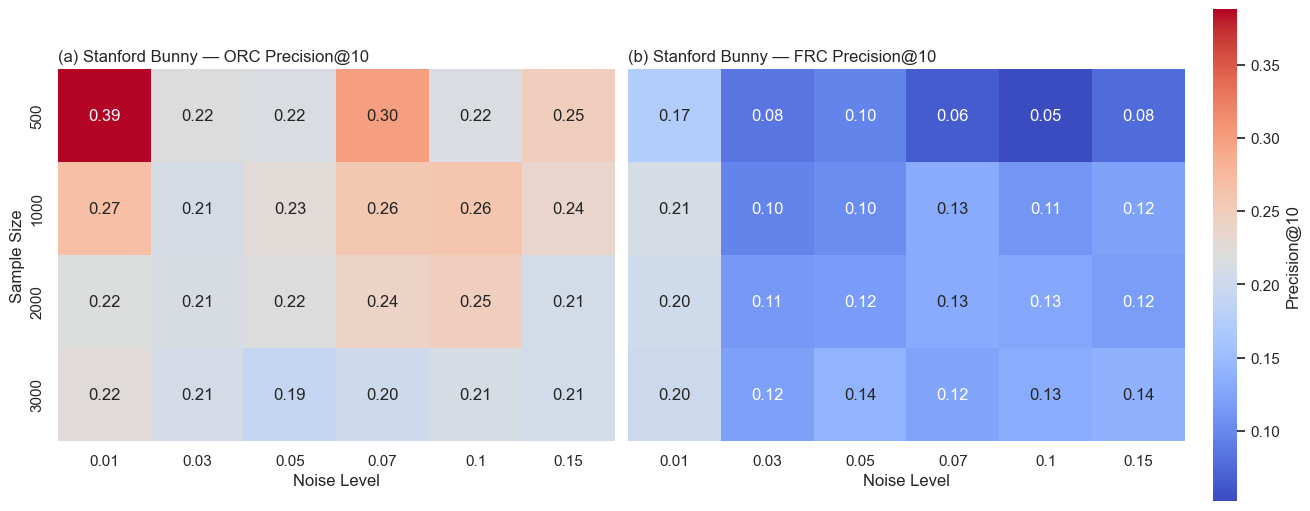

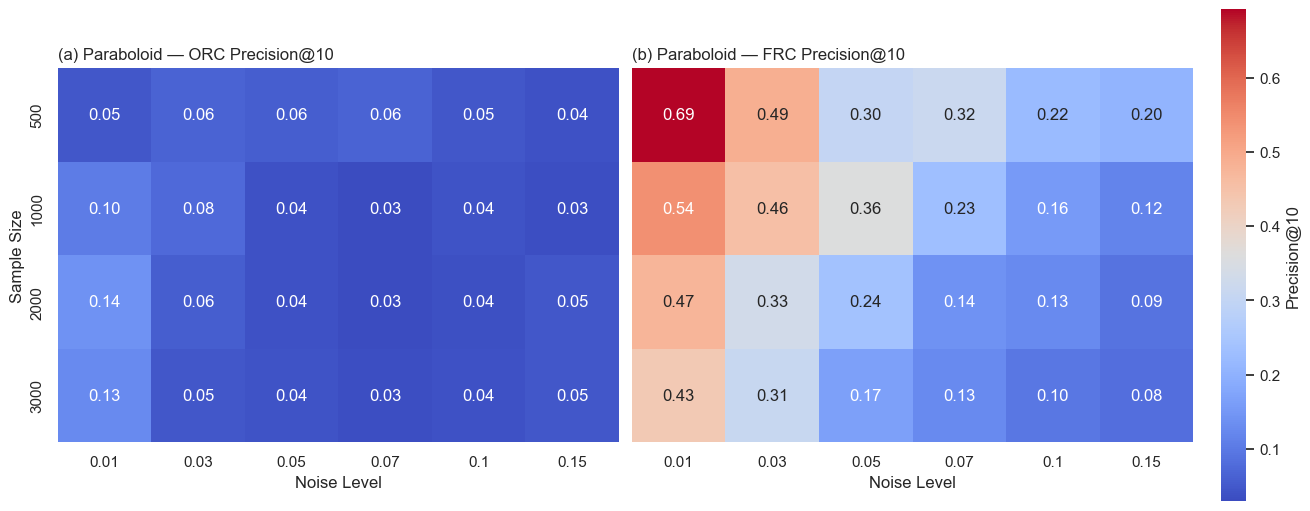

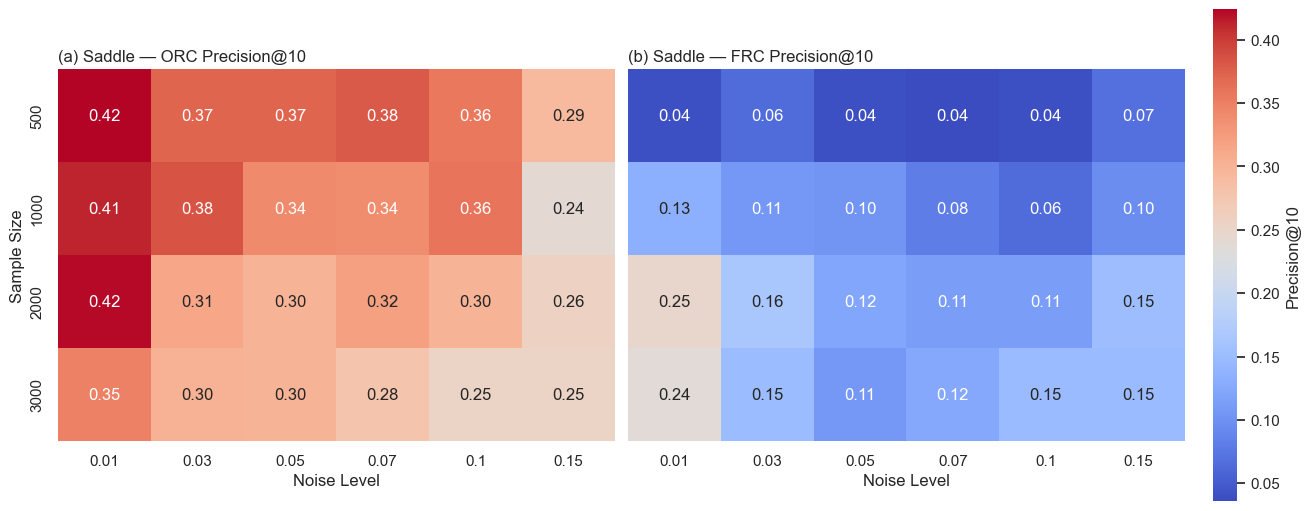

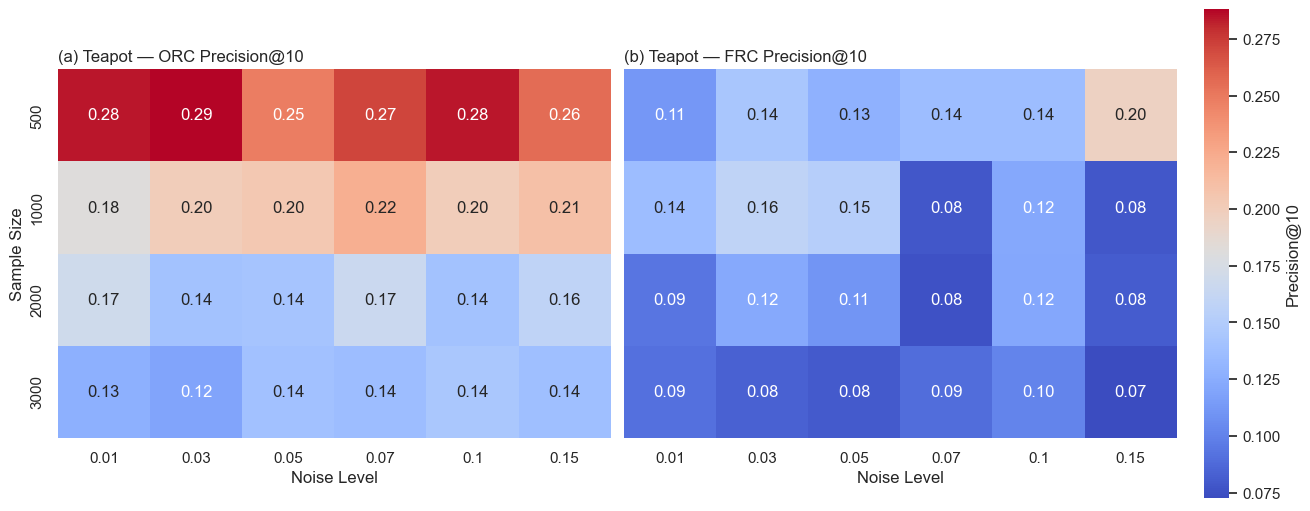

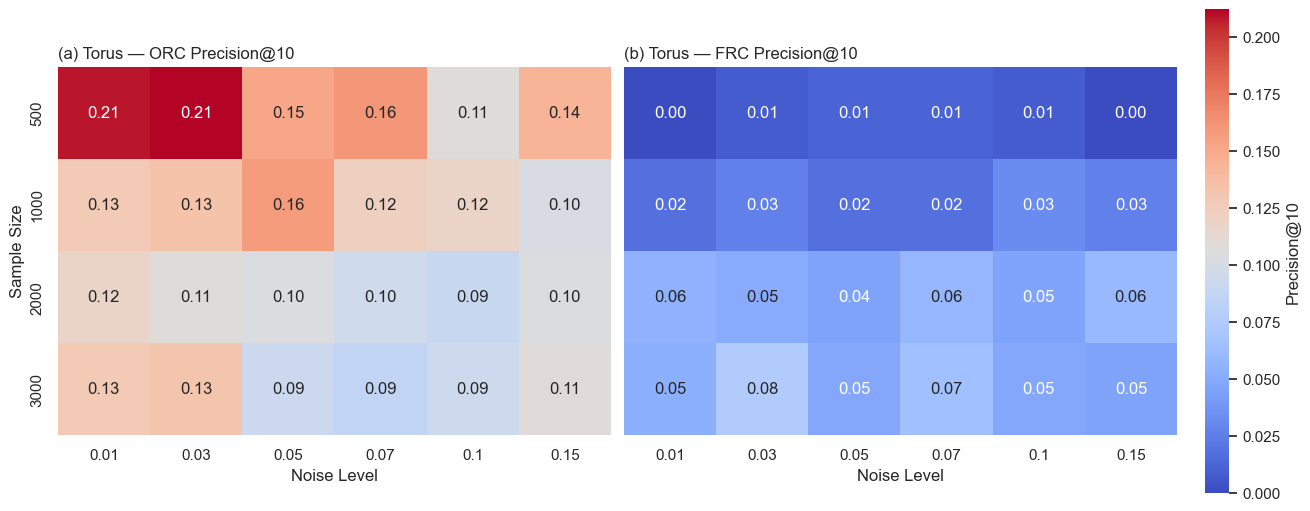

In [ ]:
# === Heatmap of precision K ===
agg_prec = (
    df.groupby(["manifold", "noise", "n"])
      .agg(
          orc_p_mean=("prec_orc", "mean"),
          frc_p_mean=("prec_frc", "mean")
      )
      .reset_index()
)

manifolds = df["manifold"].unique()
K_LABEL = "Precision@10"   

for mf in manifolds:
    sub_tbl = agg_prec[agg_prec.manifold == mf]

    orc_tbl = sub_tbl.pivot(index="n", columns="noise", values="orc_p_mean")
    frc_tbl = sub_tbl.pivot(index="n", columns="noise", values="frc_p_mean")
    combined = pd.concat([orc_tbl, frc_tbl])
    vmin, vmax = combined.min().min(), combined.max().max()

    fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharey=True, constrained_layout=True)

    # ORC
    sns.heatmap(orc_tbl, annot=True, cmap="coolwarm", fmt=".2f",
                vmin=vmin, vmax=vmax, cbar=False, ax=axes[0], square=True)
    pretty = {
        "bunny": "Stanford Bunny",
        "teapot": "Teapot",
        "paraboloid": "Paraboloid",
        "saddle": "Saddle",
        "torus": "Torus",
    }.get(str(mf).lower(), str(mf).title())
    axes[0].set_title(f"(a) {pretty} — ORC {K_LABEL}", loc="left")
    axes[0].set_xlabel("Noise Level")
    axes[0].set_ylabel("Sample Size")

    # FRC
    sns.heatmap(frc_tbl, annot=True, cmap="coolwarm", fmt=".2f",
                vmin=vmin, vmax=vmax, cbar=True, ax=axes[1], square=True,
                cbar_kws={"label": K_LABEL})
    axes[1].set_title(f"(b) {pretty} — FRC {K_LABEL}", loc="left")
    axes[1].set_xlabel("Noise Level")
    axes[1].set_ylabel("")

    out_path = FIGS / f"precision_heatmap_{mf.lower()}.pdf"
    plt.savefig(out_path, format="pdf", bbox_inches="tight")



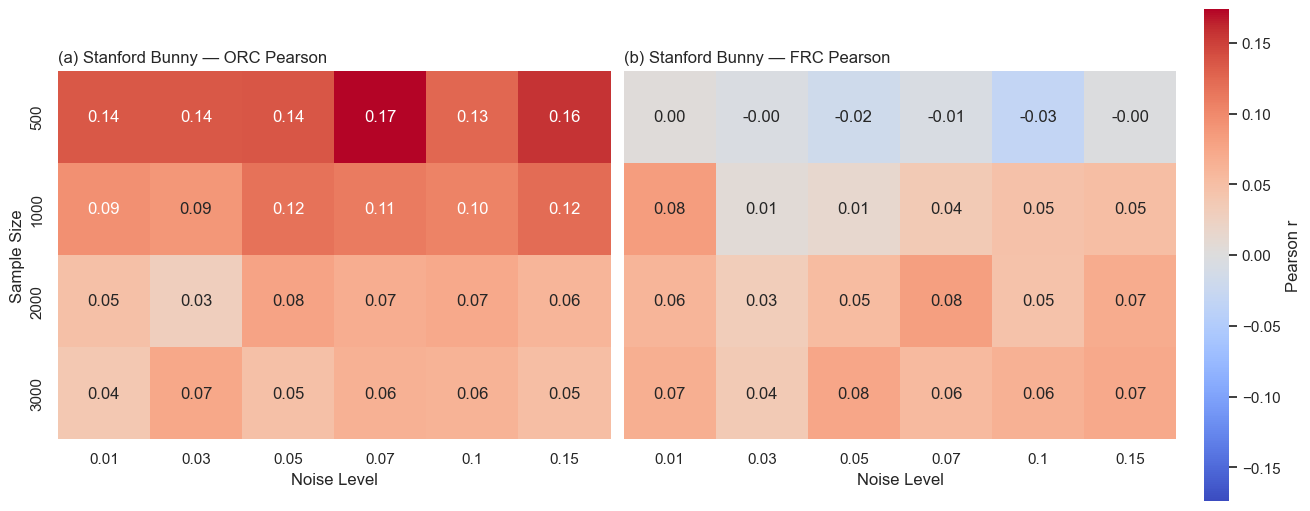

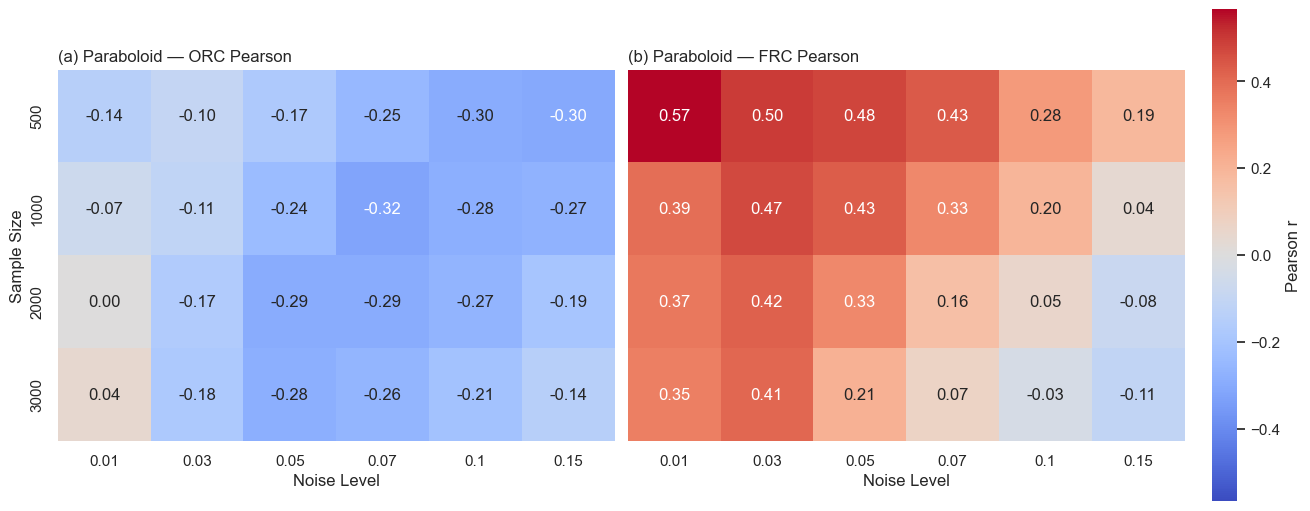

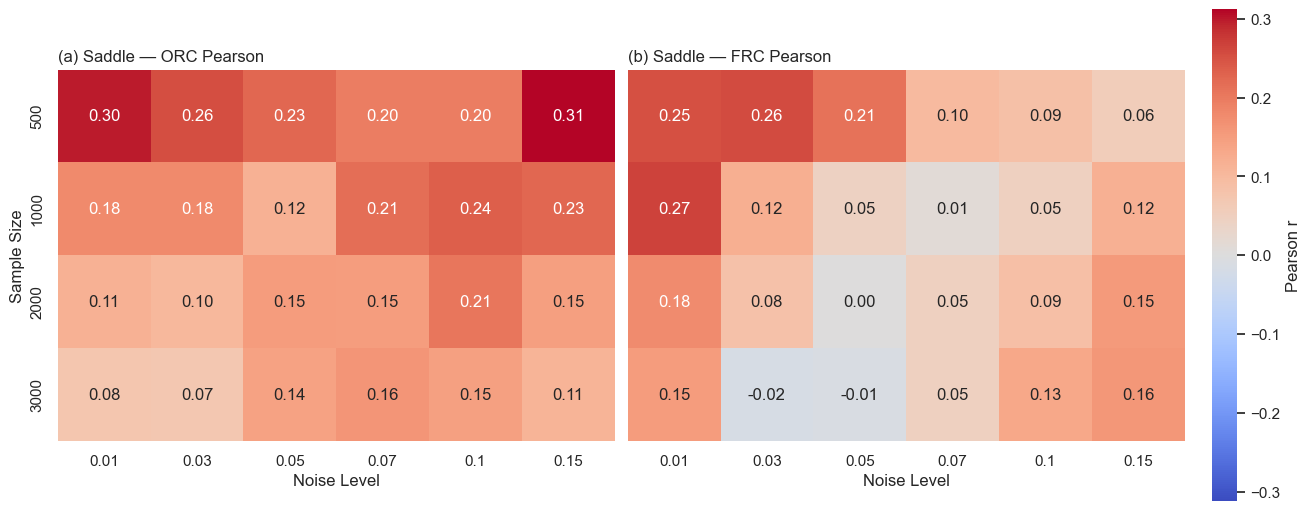

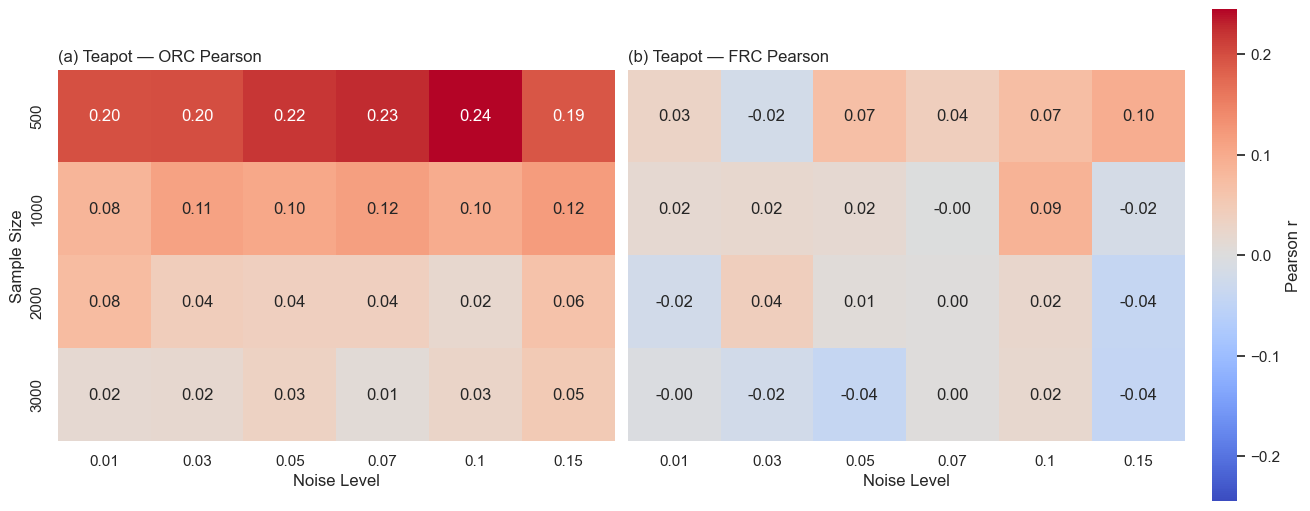

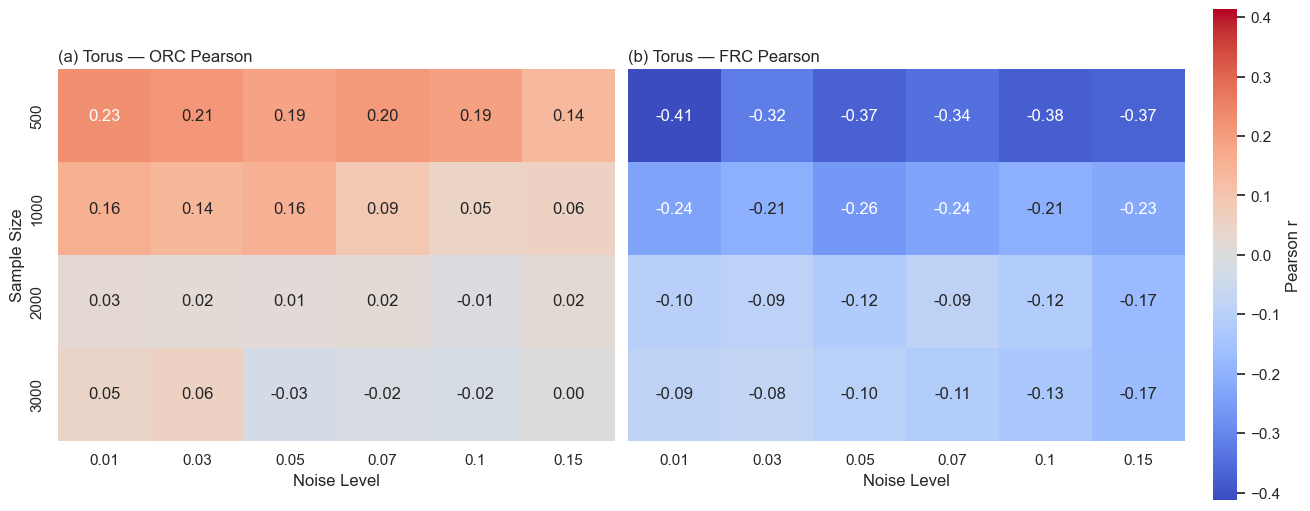

In [ ]:
# === Heatmap of Pearson
agg_tbl = (
    df.groupby(["manifold", "noise", "n"])
      .agg(
          orc_r_mean=("orc_r", "mean"),
          frc_r_mean=("frc_r", "mean")
      )
      .reset_index()
)

manifolds = df["manifold"].unique()

pretty_names = {
    "bunny": "Stanford Bunny",
    "teapot": "Teapot",
    "paraboloid": "Paraboloid",
    "saddle": "Saddle",
    "torus": "Torus",
}

for mf in manifolds:
    sub_tbl = agg_tbl[agg_tbl.manifold == mf]

    orc_tbl = sub_tbl.pivot(index="n", columns="noise", values="orc_r_mean")
    frc_tbl = sub_tbl.pivot(index="n", columns="noise", values="frc_r_mean")

    combined = pd.concat([orc_tbl, frc_tbl])
    vmax = np.nanmax(np.abs(combined.to_numpy()))
    vmin = -vmax  

    fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharey=True, constrained_layout=True)

    pretty = pretty_names.get(str(mf).lower(), str(mf).title())

    # ORC
    sns.heatmap(orc_tbl, annot=True, cmap="coolwarm", fmt=".2f",
                vmin=vmin, vmax=vmax, cbar=False, ax=axes[0], square=True)
    axes[0].set_title(f"(a) {pretty} — ORC Pearson", loc="left")
    axes[0].set_xlabel("Noise Level")
    axes[0].set_ylabel("Sample Size")

    # FRC
    sns.heatmap(frc_tbl, annot=True, cmap="coolwarm", fmt=".2f",
                vmin=vmin, vmax=vmax, cbar=True, ax=axes[1], square=True,
                cbar_kws={"label": "Pearson r"})
    axes[1].set_title(f"(b) {pretty} — FRC Pearson", loc="left")
    axes[1].set_xlabel("Noise Level")
    axes[1].set_ylabel("")

    out_path = FIGS / f"pearson_heatmap_{mf.lower()}.pdf"
    plt.savefig(out_path, format="pdf", bbox_inches="tight")

